<a href="https://colab.research.google.com/github/kmeghana758/techxobjectdetectionproject/blob/main/yolov8objectdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!mkdir -p /content/drive/MyDrive/self_driving_dataset
!mkdir -p /content/drive/MyDrive/self_driving_dataset/export/train/images
!mkdir -p /content/drive/MyDrive/self_driving_dataset/export/train/labels
!mkdir -p /content/drive/MyDrive/self_driving_dataset/export/valid/images
!mkdir -p /content/drive/MyDrive/self_driving_dataset/export/valid/labels


^C


In [17]:
!wget -O /content/drive/MyDrive/self_driving_dataset/dataset.zip "https://public.roboflow.com/ds/6SD2xYnnf4?key=F3w1J9U8nD"
!unzip /content/drive/MyDrive/self_driving_dataset/dataset.zip -d /content/drive/MyDrive/self_driving_dataset

KeyboardInterrupt: 

# Drawing Bounding Boxes

In [6]:
def yolo2bbox(bboxes):
  x_min, y_min = bboxes[0] - bboxes[2]/2, bboxes[1] - bboxes[3]/2
  x_max, y_max = bboxes[0] + bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return x_min, y_min, x_max, y_max

In [7]:
class_labels = ["biker", "car", "pedestrian", "trafficLight", "trafficLight-Green", "trafficLight-GreenLeft", "trafficLight-Red", "trafficLight-RedLeft", "trafficLight-Yellow", "trafficLight-YellowLeft", "truck"]

def draw_bboxes(image, bboxes, labels):
  h, w, _ = image.shape
  for box_num, box in enumerate(bboxes):
    x1, y1, x2, y2 = yolo2bbox(box)
    x_min = int(x1*w)
    y_min = int(y1*h)
    x_max = int(x2*w)
    y_max = int(y2*h)

    weight = max(2, int(w/275))

    match class_labels[labels[box_num]]:
      case "biker":
        label_color = (255, 0, 0)
      case "car":
        label_color = (0, 255, 0)
      case "pedestrian":
        label_color = (0, 0, 255)
      case "trafficLight":
        label_color = (255, 255, 0)
      case "trafficLight-Green":
        label_color = (128, 0, 128)
      case "trafficLight-Green":
        label_color = (0, 255, 255)
      case "trafficLight-GreenLeft":
        label_color = (128, 128, 0)
      case "trafficLight-Red":
        label_color = (255, 0, 255)
      case "trafficLight-RedLeft":
        label_color = (0, 128, 128)
      case "trafficLight-Yellow":
        label_color = (255, 128, 128)
      case "trafficLight-YellowLeft":
        label_color = (128, 255, 128)
      case "truck":
        label_color = (128, 128, 128)

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color = label_color, thickness = weight)
    cv2.putText(image, class_labels[labels[box_num]], (x_min, y_min - 10), cv2.FONT_HERSHEY_PLAIN, 1, label_color, 2)
  return image

In [8]:
def bboxes_on_images(image_paths, label_paths, num_samples):
  all_images = []
  all_images.extend(glob.glob(image_paths+'/*.jpg'))
  all_images.extend(glob.glob(image_paths+'/*.JPG'))
  all_images.sort()
  num_images = len(all_images)

  plt.figure(figsize=(15, 12))
  for i in range(num_samples):
    j = random.randint(0, num_images - 1)
    image_name = all_images[j]
    image = cv2.imread(all_images[j])
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    label_file = os.path.join(label_paths, base_name + ".txt")
    with open(label_file, 'r') as f:
      bboxes = []
      labels = []
      label_lines = f.readlines()
      for label_line in label_lines:
        parts = label_line.strip().split()
        label = int(parts[0])
        x_c, y_c, w, h = map(float, parts[1:])
        bboxes.append([x_c, y_c, w, h])
        labels.append(label)
    result_image = draw_bboxes(image, bboxes, labels)
    plt.subplot(2, 2, i+1)
    plt.imshow(result_image[:, :, ::-1])
    plt.axis('off')
  plt.subplots_adjust(wspace=1)
  plt.tight_layout


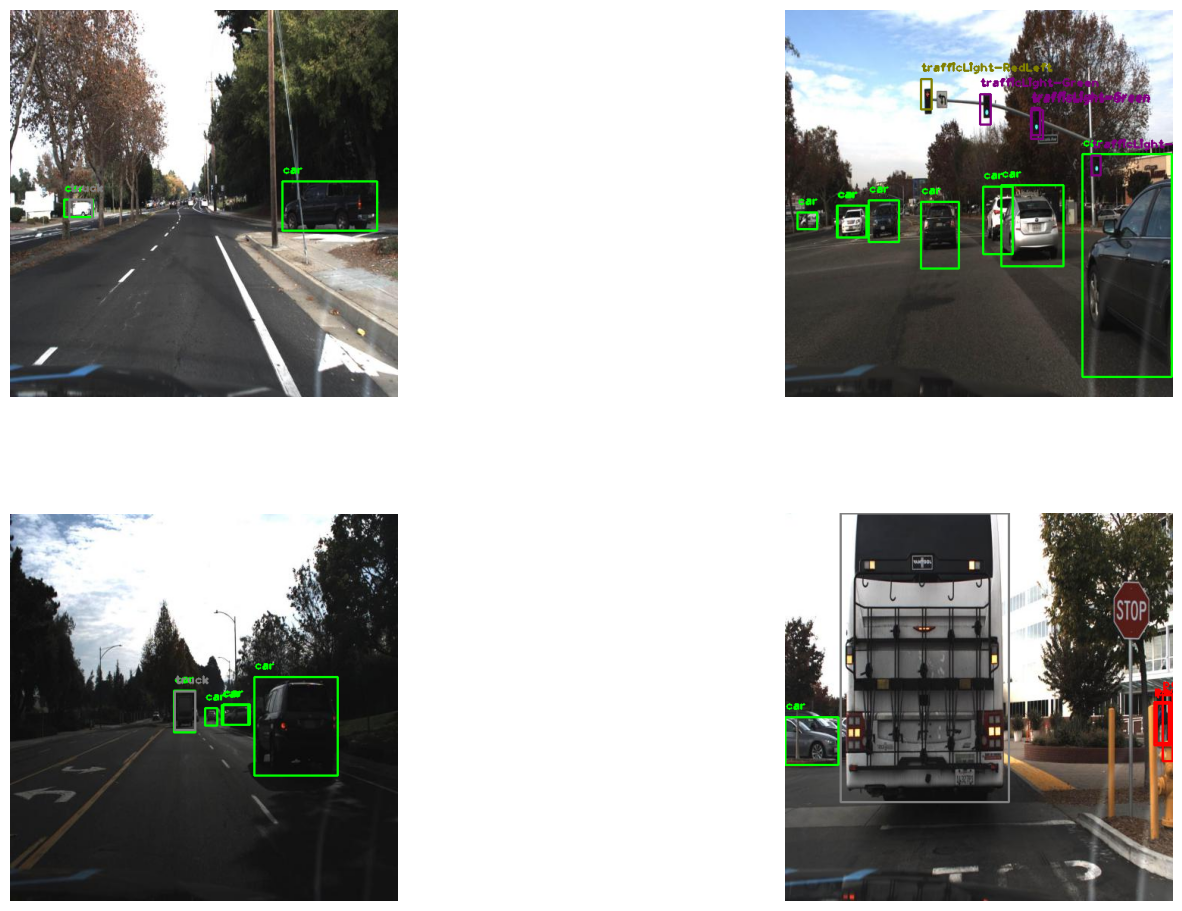

In [11]:
bboxes_on_images(
    image_paths = '/content/drive/MyDrive/self_driving_dataset/export/train/images',
    label_paths = '/content/drive/MyDrive/self_driving_dataset/export/train/labels',
    num_samples = 4
    )

# Organizing into Training and Validation Folders & Editing YAML

In [3]:
from pathlib import Path
import shutil

In [16]:
base = Path("/content/drive/MyDrive/self_driving_dataset/export")

images_dir = base / "images"
labels_dir = base / "labels"
train_img = base / "train/images"
train_lbl = base / "train/labels"
val_img = base / "valid/images"
val_lbl = base / "valid/labels"
test_img = base / "test/images"
test_lbl = base / "test/labels"

#images = list((base / "images").glob("*.jpg"))
for folder in [train_img, train_lbl, val_img, val_lbl, test_img, test_lbl]:
    folder.mkdir(parents=True, exist_ok=True)

images = list(images_dir.glob("*.jpg"))
random.shuffle(images)

train_split = int(0.7 * len(images))
val_split = int(0.85 * len(images))

train_set = images[:train_split]
val_set = images[train_split:val_split]
test_set = images[val_split:]


#split = int(0.8 * len(images))
#train_set, val_set = images[:split], images[split:]

def move_pair(img_list, dest_img, dest_lbl):
    for img in img_list:
        lbl = labels_dir / f"{img.stem}.txt"
        if not (dest_img / img.name).exists():
            shutil.move(str(img), str(dest_img / img.name))
            if lbl.exists():
                shutil.move(str(lbl), str(dest_lbl / lbl.name))

move_pair(train_set, train_img, train_lbl)
move_pair(val_set, val_img, val_lbl)
move_pair(test_set, test_img, test_lbl)

In [17]:
%%writefile /content/drive/MyDrive/self_driving_dataset/export/data.yaml
path: /content/drive/MyDrive/self_driving_dataset/export
train: train/images
val: valid/images
test: test/images
nc: 11
names: ["biker", "car", "pedestrian", "trafficLight", "trafficLight-Green", "trafficLight-GreenLeft", "trafficLight-Red", "trafficLight-RedLeft", "trafficLight-Yellow", "trafficLight-YellowLeft", "truck"]


Overwriting /content/drive/MyDrive/self_driving_dataset/export/data.yaml


# Training

In [2]:
!pip install ultralytics

## Hyperparameters

In [4]:
EPOCHS = 5
BATCH = 16
IMG_SIZE = 640

## Utilizing the YOLOv8 Nano Model

In [5]:
!yolo \
task=detect \
mode=train \
model=yolov8n.pt \
imgsz={IMG_SIZE} \
data ="/content/drive/MyDrive/self_driving_dataset/export/data.yaml" \
epochs={EPOCHS} \
batch={BATCH} \
name=yolo8n_v8_50E

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/self_driving_dataset/export/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo8n_v8_50E2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

# Evaluation on Validation Images with the Best Epoch

In [20]:
#DONT NEED THIS ANYMORE, IT VALIDATED ABOVE

!yolo \
task=detect \
mode=val \
model=/content/runs/detect/yolo8n_v8_50E4/weights/best.pt \
name=yolov8n_eval \
data="/content/drive/MyDrive/self_driving_dataset/export/data.yaml"


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 955, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/yolo/model.py", line 81, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 149, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", li

# Inference on Validation Images

In [6]:
!yolo \
task=detect \
mode=predict \
model=/content/runs/detect/yolo8n_v8_50E2/weights/best.pt \
source=/content/drive/MyDrive/self_driving_dataset/export/valid/images \
imgsz=640 \
name=yolov8n_v8_50e_infer1280 \
show_labels=False

Streaming output truncated to the last 5000 lines.
image 7622/12618 /content/drive/MyDrive/self_driving_dataset/export/valid/images/1478898117790607215_jpg.rf.Uj7CTMg6N0N258diCgDC.jpg: 640x640 2 cars, 1 pedestrian, 6.9ms
image 7623/12618 /content/drive/MyDrive/self_driving_dataset/export/valid/images/1478898118362096260_jpg.rf.614057dc23543a01ba11073ee1a66377.jpg: 640x640 1 car, 1 pedestrian, 6.8ms
image 7624/12618 /content/drive/MyDrive/self_driving_dataset/export/valid/images/1478898119504357756_jpg.rf.e881354580f70812c9151a59c7ecc135.jpg: 640x640 3 cars, 7.1ms
image 7625/12618 /content/drive/MyDrive/self_driving_dataset/export/valid/images/1478898120076205911_jpg.rf.aeee867b17afa7c7669de76dfa962b81.jpg: 640x640 1 car, 6.7ms
image 7626/12618 /content/drive/MyDrive/self_driving_dataset/export/valid/images/1478898120076205911_jpg.rf.sV3e6QHGsTXioz6b2Btv.jpg: 640x640 1 car, 6.7ms
image 7627/12618 /content/drive/MyDrive/self_driving_dataset/export/valid/images/1478898120647114366_jpg.rf.